Соловьев Н.С ds 17 + тг @NikitaSoloveoff

### Задача - разработать ML решение для автоматического определения уровня сложности англоязычных фильмов, для изучения английского языка. 

Этапы:
- импорт библиотек;
- загрузка данных;
- подготока данных к ML;
- обучение моделей, тестирование, оценка модели;
- вывод.

#### 1. Ипморт библиотек.

In [1]:
! pip install scikit-learn==1.2.0
! pip install imbalanced-learn
! pip install optuna
! pip install pystr
! pip install lightgbm
! pip install nltk
! pip install inflect
! pip install spacy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import lightgbm 
import re
import nltk
import optuna
import unicodedata
import inflect
import spacy

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### 2. Загрузка данных.

In [5]:
pth = 'C:/Users/solov/lang_range_classifare/movies_labels.xlsx'

if os.path.exists(pth):
    df = pd.read_excel(pth)
else:
    print('Загрузка не удалась')

In [6]:
df.sample()

,id,Movie,Level
232,232,Suits.S03E08.480p.HDTV.x264-mSD,C1


Данные выгрузились нормально, подтянем субтитры. Названия субтитров соотвествуют названиям фильмов, в имени добавляется только формат str. 

In [7]:
subtitles_folder = 'C:/Users/solov/lang_range_classifare/Subtitles'

for index, row in df.iterrows():
    movie_name = row['Movie']
    file_name = movie_name + '.srt'
    file_path = os.path.join(subtitles_folder, file_name)

    try:
        with open(file_path, 'r', encoding='latin-1') as file:
            subtitles = file.read()
        df.loc[index, 'Subtitles'] = subtitles
    except FileNotFoundError:
        print(f'Субтитры не найдены для: {movie_name}')
    except UnicodeDecodeError:
        print(f'Субтитры не раскодированы для: {movie_name}')

Субтитры не найдены для: The Secret Life of Pets.en
Субтитры не найдены для: Up (2009)
Субтитры не найдены для: Glass Onion
Субтитры не найдены для: Matilda(2022)
Субтитры не найдены для: Bullet train
Субтитры не найдены для: Thor: love and thunder
Субтитры не найдены для: Lightyear
Субтитры не найдены для: The Grinch


In [8]:
print (df['Subtitles'][0])

1
00:00:55,279 --> 00:01:07,279
<font color="#ffff80"><b>Fixed & Synced by bozxphd. Enjoy The Flick</b></font>

2
00:01:11,280 --> 00:01:12,838
(CLANGING)

3
00:01:16,480 --> 00:01:17,833
(DRAWER CLOSES)

4
00:01:55,800 --> 00:01:57,597
(INAUDIBLE)

5
00:04:07,800 --> 00:04:09,313
(CELL PHONE RINGING)

6
00:04:20,200 --> 00:04:22,919
BEN ON PHONE: <i>Michelle,<br/>please don't hang up.</i>

7
00:04:23,680 --> 00:04:27,673
<i>Just talk to me, okay?<br/>I can't believe you just left.</i>

8
00:04:28,840 --> 00:04:30,068
<i>Michelle.</i>

9
00:04:30,920 --> 00:04:32,273
<i>Come back.</i>

10
00:04:34,200 --> 00:04:35,872
<i>Please say something.</i>

11
00:04:37,360 --> 00:04:39,555
<i>Michelle, talk to me.</i>

12
00:04:40,800 --> 00:04:42,950
<i>Look, we had an argument.<br/>Couples fight.</i>

13
00:04:43,040 --> 00:04:45,713
<i>That is no reason<br/>to just leave everything behind.</i>

14
00:04:48,040 --> 00:04:50,349
<i>Running away isn't gonna help it any.<br/>Michelle, please...</

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         241 non-null    int64 
 1   Movie      241 non-null    object
 2   Level      241 non-null    object
 3   Subtitles  233 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.7+ KB


#### 3. Подготовка данных к ML

Удалим строки с недостающими значениями. 

In [10]:
df = df.dropna(how='any',axis=0).reset_index(drop = True)
df = df.drop(['id'], axis = 1)

In [11]:
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

Класс А1 - самый начальный не представлен в дф, очевидно что с таким уровнем знания языка - рано учить английский по фильмам, нужно подтянуть теорию. С2 - профессиональное владение, насколько я изучил информацию до сих пор идет спор среди ученых - может ли не носитель языка освоить не родной язык на таком уровне. В любом случае на этом уровне уже не требуется учить язык. Уровней + нет в словаре, там где несколько уровней оставим тот - который сложнее. Если пользователь посмотрит несколько фильмов и ничего не поймет - мотивация изучать язык таким образом скорее всего станет ниже чем, если после просмотра фильм покажется чуть проще чем хотелось бы. 

In [12]:
df['Level'] = df['Level'].replace({'A2/A2+': 'A2', 'B1, B2': 'B2', 'A2/A2+, B1': 'B1'})

In [13]:
df['Level'].value_counts()

B2    105
B1     58
C1     39
A2     31
Name: Level, dtype: int64

дисбаланс

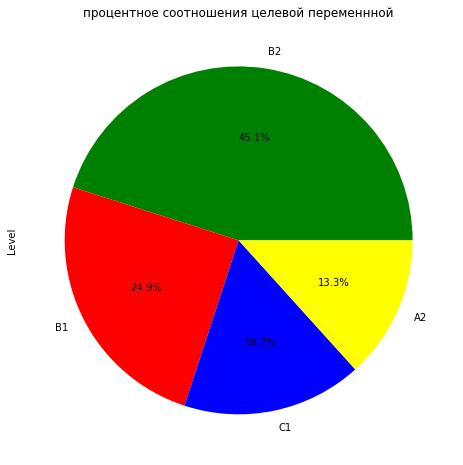

In [14]:
figure, ax=plt.subplots(figsize=(12,8))
labels = 'B2', 'B1', 'C1', 'A2'
colors = 'Green', 'Red', 'Blue', 'Yellow'
df['Level'].value_counts().plot.pie(explode=None, colors = colors, labels = labels, autopct='%1.1f%%',ax=ax)
ax.set_title('процентное соотношения целевой переменнной')
plt.show()

явный дисбаланс целевой переменной. Данных так же не много. Нам предоставили возможность скачивать srt для любых фильмов и добавлять их, но я не представляю как заранее оценить фильм по уровню. Так можно скорее еще больше внести дисбаланс. Я думал синтезировать фильмы и субтитры к ним по категориям сложности которых меньше, но куратор мастерской сказал не нужно. Значит будем работать с тем что есть.

In [ ]:
df['Subtitles'] = df['Subtitles'].astype(str)

In [15]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
regex = re.compile(r'[^\w\s]')

def is_word_in_wordnet(word):
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

def clean_text(input_text):
    clean_text = re.sub('<[^<]+?>|http\S+', '', input_text)
    clean_text = re.sub('\s+', ' ', clean_text.lower())
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    clean_text = re.sub('\d', '', clean_text)
    tokens = [token for token in word_tokenize(clean_text) if token not in stop_words and is_word_in_wordnet(token)]
    doc = nlp(' '.join(tokens))
    clean_text = regex.sub('', ' '.join([token.lemma_ for token in doc]))
    return clean_text

в этой функции мы предобрабатываем субтитры: сначала is_word_in_wordnet проверяем есть ли слово в словаре nltk ( добавил когда после обработки появились не существующие слова) , потом clean_text, приводим в нижний регистр, c помощью re регуляных выражений удаляем HTML-теги, лишние символы, знаки, цифры и все символы которые не буквы, удаляем лишние пробелы, удаляем символы типа Unicode, исправляем сокращения используя библиотеку contractions, удаляем стоп слова с помощью nltk, разбиваем на отдельные слова (токены), фильтруем через словарь wordnet и убирая стоп слова, лемматизация слов с помощью spacy и возвращаем очищенный текст убтитров.

In [16]:
df['Subtitles'] = df['Subtitles'].apply(clean_text)

посмотрим что получилось

In [17]:
print (df['Subtitles'][0])

fix synced enjoy flick clang drawer close inaudible cell phone ring ben phone please hang talk okay can believe leave come back please say talk look fight leave behind run away na help please newscaster detail elsewhere today power still restore many city southern seaboard wake afternoon widespread blackout inclement weather region problem seem link authority call catastrophic power crippled traffic area loud crash grunt tire screech scream glass shatter gasp groan horn honk inhale deeply sniff sigh gasp chain rattle breathe heavily grunt groan groan grunt sobs chain jangling sob breathe heavily damn clatter grunt rumble footstep approach pant gasp door creak okay okay please please please hurt breathing heavily please let go okay tell promise okay please let go please man need shock go go keep alive work get handy boyfriend expect send cop look sorry one look clang grunt groan softly grunt exhale scrape breathe heavily sigh cough fire alarm beep rapid footstep approach door open gasps

уже выглядит лучше.

разобъем на тест и трейн, тк дисбаланс статифицируем целевую переменную.

In [18]:
RS = 12345

train_df, test_df = train_test_split(df, test_size=0.31, random_state=RS, stratify=df['Level'])

In [19]:
print (train_df.shape)
print (test_df.shape)

(160, 3)
(73, 3)


преобразуем субтитры в матрицу посчета слов, где каждый элемент показывает колличество вхождение слова в текст субтитров.

In [20]:
vectorizer = CountVectorizer()

X_train_counts = vectorizer.fit_transform(train_df['Subtitles'])
X_test_counts = vectorizer.transform(test_df['Subtitles'])

преобразуем в матрицу tfidf где каждый элемент показывает значимость слова в тексте основываясь на его частоте и значимости в корпусе текстов

In [21]:
tfidf_transformer = TfidfTransformer()

X_train = tfidf_transformer.fit_transform(X_train_counts)
X_test = tfidf_transformer.transform(X_test_counts)

преобразуем метки классов в числовые значения, сохранив при этом порядок классов. 

In [23]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train_df['Level'])
y_test = encoder.transform(test_df['Level'])

применим метод smote для сбалансированного увеличения выборки синтетическимии метками класса 

In [24]:
smote = SMOTE(random_state=RS)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Обучение моделей

Логистическая регрессия показала себя очень посредственно. Решил попробовать MultinomialNB - вероятностную модель основанную на байесовском классификаторе, по описанию и примерам она хорошо подходит для текстов, так же попробую метод опорных векторов SVC который хорошо работает с общими признаками в большом пространстве и так же неплохо справляется с мультиклассификацией. Тут можно использовать Optuna тк модели достаточно быстрые.

In [25]:
def objective_multinomial_nb(trial):
    alpha = trial.suggest_float('alpha', 0.01, 10)
    classifier = MultinomialNB(alpha=alpha)
    scores = cross_val_score(classifier, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    return scores.mean()

multinomial_nb_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RS))
multinomial_nb_study.optimize(objective_multinomial_nb, n_trials=300)
best_multinomial_nb_params = multinomial_nb_study.best_params
best_multinomial_nb_model = MultinomialNB(alpha=best_multinomial_nb_params['alpha'])
best_multinomial_nb_model.fit(X_train_resampled, y_train_resampled)
best_multinomial_nb_accuracy = cross_val_score(best_multinomial_nb_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()

[I 2023-07-17 19:54:47,933] A new study created in memory with name: no-name-275390a9-8af9-4ee7-8fb4-9f35d34c9cd8
[I 2023-07-17 19:54:48,407] Trial 0 finished with value: 0.5698124621899576 and parameters: {'alpha': 9.296864767243306}. Best is trial 0 with value: 0.5698124621899576.
[I 2023-07-17 19:54:48,465] Trial 1 finished with value: 0.615124016938899 and parameters: {'alpha': 3.170591790272041}. Best is trial 1 with value: 0.615124016938899.
[I 2023-07-17 19:54:48,531] Trial 2 finished with value: 0.6462189957652752 and parameters: {'alpha': 1.8473489286541735}. Best is trial 2 with value: 0.6462189957652752.
[I 2023-07-17 19:54:48,593] Trial 3 finished with value: 0.6427707199032062 and parameters: {'alpha': 2.0535571827448664}. Best is trial 2 with value: 0.6462189957652752.
[I 2023-07-17 19:54:48,648] Trial 4 finished with value: 0.5872958257713249 and parameters: {'alpha': 5.681573040526049}. Best is trial 2 with value: 0.6462189957652752.
[I 2023-07-17 19:54:48,710] Trial 5 

[I 2023-07-17 19:54:51,497] Trial 44 finished with value: 0.6670901391409558 and parameters: {'alpha': 1.3391149909237734}. Best is trial 34 with value: 0.8300060496067756.
[I 2023-07-17 19:54:51,566] Trial 45 finished with value: 0.6877797943133697 and parameters: {'alpha': 0.46602979232277025}. Best is trial 34 with value: 0.8300060496067756.
[I 2023-07-17 19:54:51,631] Trial 46 finished with value: 0.6877797943133697 and parameters: {'alpha': 0.5442841190973701}. Best is trial 34 with value: 0.8300060496067756.
[I 2023-07-17 19:54:51,702] Trial 47 finished with value: 0.6809437386569873 and parameters: {'alpha': 1.0541568135926798}. Best is trial 34 with value: 0.8300060496067756.
[I 2023-07-17 19:54:51,770] Trial 48 finished with value: 0.6877797943133697 and parameters: {'alpha': 0.4668762366414657}. Best is trial 34 with value: 0.8300060496067756.
[I 2023-07-17 19:54:51,836] Trial 49 finished with value: 0.8264972776769509 and parameters: {'alpha': 0.0412124988926736}. Best is tr

[I 2023-07-17 19:54:54,395] Trial 88 finished with value: 0.6843315184513006 and parameters: {'alpha': 0.5933218227310421}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:54,463] Trial 89 finished with value: 0.7468239564428313 and parameters: {'alpha': 0.23612196747088068}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:54,527] Trial 90 finished with value: 0.6877797943133697 and parameters: {'alpha': 0.5612423125795762}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:54,578] Trial 91 finished with value: 0.8300060496067756 and parameters: {'alpha': 0.0398625944098894}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:54,646] Trial 92 finished with value: 0.7328493647912886 and parameters: {'alpha': 0.25986202126946734}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:54,716] Trial 93 finished with value: 0.8300060496067756 and parameters: {'alpha': 0.0401364793499415}. Best is t

[I 2023-07-17 19:54:57,478] Trial 132 finished with value: 0.7710828796128251 and parameters: {'alpha': 0.16876719763316544}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:57,543] Trial 133 finished with value: 0.6843315184513006 and parameters: {'alpha': 0.6003094338513683}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:57,596] Trial 134 finished with value: 0.7537205081669691 and parameters: {'alpha': 0.22866796271902695}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:57,662] Trial 135 finished with value: 0.8231094978826377 and parameters: {'alpha': 0.020518497117383825}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:57,726] Trial 136 finished with value: 0.8264972776769511 and parameters: {'alpha': 0.01236089998512259}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:54:57,777] Trial 137 finished with value: 0.6116152450090744 and parameters: {'alpha': 3.42255065137788}. Be

[I 2023-07-17 19:55:00,512] Trial 176 finished with value: 0.6843315184513006 and parameters: {'alpha': 0.631218729108056}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:00,580] Trial 177 finished with value: 0.5872958257713249 and parameters: {'alpha': 6.479420470492655}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:00,647] Trial 178 finished with value: 0.5803387779794313 and parameters: {'alpha': 8.036709717895333}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:00,693] Trial 179 finished with value: 0.7675741076830006 and parameters: {'alpha': 0.18913007891875933}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:00,760] Trial 180 finished with value: 0.6808832425892317 and parameters: {'alpha': 0.8202194057946938}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:00,827] Trial 181 finished with value: 0.8300060496067756 and parameters: {'alpha': 0.029106677841758067}. Best 

[I 2023-07-17 19:55:03,422] Trial 220 finished with value: 0.604779189352692 and parameters: {'alpha': 4.006635572392015}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:03,506] Trial 221 finished with value: 0.7816091954022988 and parameters: {'alpha': 0.1553378752252614}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:03,559] Trial 222 finished with value: 0.8265577737447065 and parameters: {'alpha': 0.0195493465785131}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:03,645] Trial 223 finished with value: 0.7675741076830006 and parameters: {'alpha': 0.1868867482068597}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:03,711] Trial 224 finished with value: 0.8300060496067756 and parameters: {'alpha': 0.03393648689324118}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:03,773] Trial 225 finished with value: 0.6981246218995765 and parameters: {'alpha': 0.3750129040968947}. Best i

[I 2023-07-17 19:55:06,539] Trial 264 finished with value: 0.7084694494857835 and parameters: {'alpha': 0.3276006793715094}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:06,590] Trial 265 finished with value: 0.6912885662431942 and parameters: {'alpha': 0.5274902649135248}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:06,657] Trial 266 finished with value: 0.5872958257713249 and parameters: {'alpha': 6.133421692031448}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:06,733] Trial 267 finished with value: 0.5837870538415002 and parameters: {'alpha': 7.282780143461483}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:06,791] Trial 268 finished with value: 0.7675741076830006 and parameters: {'alpha': 0.2046144832656263}. Best is trial 63 with value: 0.8334543254688447.
[I 2023-07-17 19:55:06,857] Trial 269 finished with value: 0.6427707199032062 and parameters: {'alpha': 1.9975607345957667}. Best is

In [26]:
def objective_svm(trial):
    C = trial.suggest_uniform('C', 0.1, 10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    classifier = SVC(C=C, kernel=kernel, random_state=RS, decision_function_shape='ovr')
    scores = cross_val_score(classifier, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    return scores.mean()

svm_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RS))
svm_study.optimize(objective_svm, n_trials=100)
best_svm_params = svm_study.best_params
best_svm_model = SVC(C=best_svm_params['C'], kernel=best_svm_params['kernel'], random_state=RS, decision_function_shape='ovr')
best_svm_model.fit(X_train_resampled, y_train_resampled)
best_svm_accuracy = cross_val_score(best_svm_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()

[I 2023-07-17 19:55:09,051] A new study created in memory with name: no-name-b0b4cfd3-7507-4138-ab84-2dae9a864636
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:55:12,803] Trial 0 finished with value: 0.8889897156684816 and parameters: {'C': 9.303199318889764, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:55:17,221] Trial 1 finished with va

[I 2023-07-17 19:56:07,601] Trial 15 finished with value: 0.8889897156684816 and parameters: {'C': 5.103306921095677, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:56:10,894] Trial 16 finished with value: 0.8889897156684816 and parameters: {'C': 8.679275469595487, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_

[I 2023-07-17 19:57:00,383] Trial 31 finished with value: 0.8889897156684816 and parameters: {'C': 7.375191634085578, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:57:03,933] Trial 32 finished with value: 0.8889897156684816 and parameters: {'C': 5.814861397316867, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_

[I 2023-07-17 19:57:57,971] Trial 47 finished with value: 0.8889897156684816 and parameters: {'C': 8.340365191635051, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:58:01,344] Trial 48 finished with value: 0.8889897156684816 and parameters: {'C': 4.648322084055527, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_

[I 2023-07-17 19:58:51,255] Trial 63 finished with value: 0.8889897156684816 and parameters: {'C': 8.957875567443784, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:58:54,427] Trial 64 finished with value: 0.8889897156684816 and parameters: {'C': 7.792420819766473, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_

[I 2023-07-17 19:59:44,116] Trial 79 finished with value: 0.8889897156684816 and parameters: {'C': 9.3685192153647, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 19:59:47,264] Trial 80 finished with value: 0.8889897156684816 and parameters: {'C': 7.742027089157894, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_un

[I 2023-07-17 20:00:37,609] Trial 95 finished with value: 0.8889897156684816 and parameters: {'C': 5.531729511701387, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 20:00:41,108] Trial 96 finished with value: 0.8889897156684816 and parameters: {'C': 8.521411219677004, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_

In [27]:
results = pd.DataFrame({
    'Модель': ['MultinomialNB', 'SVС'],
    'Точность': [best_multinomial_nb_accuracy, best_svm_accuracy],
    'Параметры': [best_multinomial_nb_params, best_svm_params]
})

print("\nРезультаты:")
print(results)


Результаты:
          Модель  Точность                                     Параметры
0  MultinomialNB  0.833454                {'alpha': 0.04840681378417124}
1            SVС  0.888990  {'C': 9.303199318889764, 'kernel': 'linear'}


По результатам лучшую точность (и скорость работы) показала модель SVC с параметрами 'C': 9.303199318889764, 'kernel': 'linear'

тестирование лучшей модели:

In [30]:
predictions = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='weighted')

print(accuracy)
print(f1)

0.726027397260274
0.7260383761259577


#### Вывод

В ходе выполнения задачи, самую большую сложность представляет этап предобработки субтитров в список существующих слов, без всех посторонних символов. Думаю что это актуально для любой nlp и очевидно что признак в виде очищенного текста - получается очень 'громозким'. Сложные модели (бустинги) скорее всего показали бы более высокую точность, но считают они очень долго, необходимы ресурсы другого уровня, точно не локальные. Так же возможно использовать нейронки, но углубляться в эту тему самостоятельно за небольшое время - не лучшее решение. 

Лучшей моделью в данной ситуации показала себя SVC с точностью 0.72 и ф1 мерой 0.72. 